# Conversational RAG

:::info Prerequisites

This guide assumes familiarity with the following concepts:

- [Chat history](/docs/concepts/chat_history)
- [Chat models](/docs/concepts/chat_models)
- [Embeddings](/docs/concepts/embedding_models)
- [Vector stores](/docs/concepts/vectorstores)
- [Retrieval-augmented generation](/docs/tutorials/rag/)
- [Tools](/docs/concepts/tools)
- [Agents](/docs/concepts/agents)

:::

In many Q&A applications we want to allow the user to have a back-and-forth conversation, meaning the application needs some sort of "memory" of past questions and answers, and some logic for incorporating those into its current thinking.

In this guide we focus on **adding logic for incorporating historical messages.** Further details on chat history management is [covered here](/docs/how_to/message_history).

We will cover two approaches:

1. [Chains](/docs/tutorials/qa_chat_history/#chains), in which we execute at most one retrieval step;
2. [Agents](/docs/tutorials/qa_chat_history/#agents), in which we give an LLM discretion to execute multiple retrieval steps.

::: note

The methods presented here leverage [tool-calling](/docs/concepts/tool_calling/) capabilities in modern chat models. For an approach that does not require tool calling, refer to the v0.2 guide [here](https://python.langchain.com/v0.2/docs/tutorials/qa_chat_history/#chains).

:::

For the external knowledge source, we will use the same [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng from the [RAG tutorial](/docs/tutorials/rag).

## Setup

### Components

We will need to select three components from LangChain's suite of integrations.

A [chat model](/docs/integrations/chat/):

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />

In [ ]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

An [embedding model](/docs/integrations/text_embedding/):

import EmbeddingTabs from "@theme/EmbeddingTabs";

<EmbeddingTabs/>

In [ ]:
# | output: false
# | echo: false

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

And a [vector store](/docs/integrations/vectorstores/):

import VectorStoreTabs from "@theme/VectorStoreTabs";

<VectorStoreTabs/>

In [ ]:
# | output: false
# | echo: false

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### Dependencies

In addition, we'll use the following packages:

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

### LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with [LangSmith](https://smith.langchain.com).

Note that LangSmith is not needed, but it is helpful. If you do want to use LangSmith, after you sign up at the link above, make sure to set your environment variables to start logging traces:

```python
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
```

## Chains {#chains}

Let's first revisit the vector store we built in the [RAG tutorial](/docs/tutorials/rag), which indexes an [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog post by Lilian Weng.

In [59]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks and make retriever object
_ = vector_store.add_documents(documents=all_splits)

Conversational experiences can be represented using a sequence of [messages](/docs/concepts/messages/). In addition to messages from the user and assistant, retrieved documents and other artifacts can be incorporated into a message sequence via [tool messages](/docs/concepts/messages/#toolmessage). This motivates us to represent the state of our RAG application using a sequence of messages.

This model for state is so versatile that LangGraph offers a built-in version for convenience:

In [49]:
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

In the [RAG tutorial](/docs/tutorials/rag), we represented retrieved context via a separate key in the state. Here, we can simply incorporate them into the message sequence as tool messages.

Leveraging [tool-calling](/docs/concepts/tool_calling/) to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model. This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

> Human: What is Task Decomposition?  
> AI: \<Answer informed by search.\>  
> Human: What are some common ways of doing it?

In this scenario, a model could generate a query such as `"common approaches to task decomposition"`. Tool-calling facilitates this naturally. As in the [query analysis](/docs/tutorials/rag#query-analysis) section of the RAG tutorial, this allows a model to rewrite user queries into more effective search queries. It also provides support for direct responses that do not involve a retrieval step (e.g., in response to a generic greeting from the user).

Let's turn our retrieval step into a tool:

In [55]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

TODO: add context

In [29]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


tools = ToolNode([retrieve])


def generate(state: MessagesState):
    """Generate answer."""
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        "{context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            MessagesPlaceholder("chat_history"),
        ]
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    last_message = state["messages"][-1]  # will be ToolMessage
    docs = last_message.content

    chain = prompt | llm | StrOutputParser()

    # Run
    response = chain.invoke({"context": docs, "chat_history": conversation_messages})
    return {"messages": [response]}


# Build graph
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

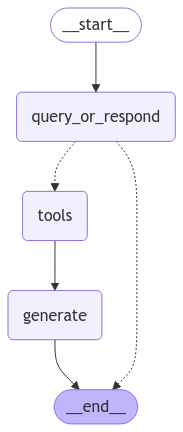

In [30]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [60]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [8]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Y300T44MuLsgB4fOuRD9tx1k)
 Call ID: call_Y300T44MuLsgB4fOuRD9tx1k
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

### Stateful management of chat history

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [20]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [21]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ST8vcADgOo6JbEs3MI2OsMIL)
 Call ID: call_ST8vcADgOo6JbEs3MI2OsMIL
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms b

In [22]:
input_message = "Can you look up one way of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up one way of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Nba7n5HbdsxRyrmlXqKf1YqD)
 Call ID: call_Nba7n5HbdsxRyrmlXqKf1YqD
  Args:
    query: Task Decomposition techniques
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler ste

## Agents {#agents}

Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allow you to offload some discretion over the retrieval process. Although their behavior is less predictable than chains, they offer some advantages in this context:

- Agents generate the input to the retriever directly, without necessarily needing us to explicitly build in contextualization, as we did above;
- Agents can execute multiple retrieval steps in service of a query, or refrain from executing a retrieval step altogether (e.g., in response to a generic greeting from a user).

In [46]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

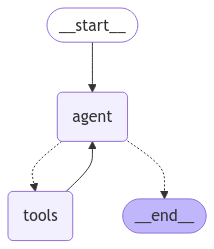

In [48]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [47]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_NWL0QEue9xZPTLZ6q5k4MoUX)
 Call ID: call_NWL0QEue9xZPTLZ6q5k4MoUX
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori

# OLD STUFF BELOW

In [3]:
import bs4
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 1. Load, chunk and index the contents of the blog to create a retriever.
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()


# 2. Incorporate the retriever into a question-answering chain.
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [4]:
response = rag_chain.invoke({"input": "What is Task Decomposition?"})
response["answer"]

"Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance this process by guiding models to think step by step and explore multiple reasoning possibilities. This approach helps in simplifying complex tasks and provides insight into the model's reasoning."

Note that we have used the built-in chain constructors `create_stuff_documents_chain` and `create_retrieval_chain`, so that the basic ingredients to our solution are:

1. retriever;
2. prompt;
3. LLM.

This will simplify the process of incorporating chat history.

### Adding chat history

The chain we have built uses the input query directly to retrieve relevant context. But in a conversational setting, the user query might require conversational context to be understood. For example, consider this exchange:

> Human: "What is Task Decomposition?"
>
> AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."
>
> Human: "What are common ways of doing it?"

In order to answer the second question, our system needs to understand that "it" refers to "Task Decomposition."

We'll need to update two things about our existing app:

1. **Prompt**: Update our prompt to support historical messages as an input.
2. **Contextualizing questions**: Add a sub-chain that takes the latest user question and reformulates it in the context of the chat history. This can be thought of simply as building a new "history aware" retriever. Whereas before we had:
   - `query` -> `retriever`  
     Now we will have:
   - `(query, conversation history)` -> `LLM` -> `rephrased query` -> `retriever`

#### Contextualizing the question

First we'll need to define a sub-chain that takes historical messages and the latest user question, and reformulates the question if it makes reference to any information in the historical information.

We'll use a prompt that includes a `MessagesPlaceholder` variable under the name "chat_history". This allows us to pass in a list of Messages to the prompt using the "chat_history" input key, and these messages will be inserted after the system message and before the human message containing the latest question.

Note that we leverage a helper function [create_history_aware_retriever](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.history_aware_retriever.create_history_aware_retriever.html) for this step, which manages the case where `chat_history` is empty, and otherwise applies `prompt | llm | StrOutputParser() | retriever` in sequence.

`create_history_aware_retriever` constructs a chain that accepts keys `input` and `chat_history` as input, and has the same output schema as a retriever.

In [5]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

This chain prepends a rephrasing of the input query to our retriever, so that the retrieval incorporates the context of the conversation.

Now we can build our full QA chain. This is as simple as updating the retriever to be our new `history_aware_retriever`.

Again, we will use [create_stuff_documents_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html) to generate a `question_answer_chain`, with input keys `context`, `chat_history`, and `input`-- it accepts the retrieved context alongside the conversation history and query to generate an answer. A more detailed explaination is over [here](/docs/tutorials/rag/).

We build our final `rag_chain` with [create_retrieval_chain](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.retrieval.create_retrieval_chain.html). This chain applies the `history_aware_retriever` and `question_answer_chain` in sequence, retaining intermediate outputs such as the retrieved context for convenience. It has input keys `input` and `chat_history`, and includes `input`, `chat_history`, `context`, and `answer` in its output.

In [6]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

Let's try this. Below we ask a question and a follow-up question that requires contextualization to return a sensible response. Because our chain includes a `"chat_history"` input, the caller needs to manage the chat history. We can achieve this by appending input and output messages to a list:

In [7]:
from langchain_core.messages import AIMessage, HumanMessage

chat_history = []

question = "What is Task Decomposition?"
ai_msg_1 = rag_chain.invoke({"input": question, "chat_history": chat_history})
chat_history.extend(
    [
        HumanMessage(content=question),
        AIMessage(content=ai_msg_1["answer"]),
    ]
)

second_question = "What are common ways of doing it?"
ai_msg_2 = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

print(ai_msg_2["answer"])

Common ways of task decomposition include using simple prompting techniques, such as asking for "Steps for XYZ" or "What are the subgoals for achieving XYZ?" Additionally, task-specific instructions can be employed, like "Write a story outline" for writing tasks, or human inputs can guide the decomposition process.


:::tip

Check out the [LangSmith trace](https://smith.langchain.com/public/243301e4-4cc5-4e52-a6e7-8cfe9208398d/r).

:::

#### Stateful management of chat history

:::note

This section of the tutorial previously used the [RunnableWithMessageHistory](https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html) abstraction. You can access that version of the documentation in the [v0.2 docs](https://python.langchain.com/v0.2/docs/tutorials/chatbot/).

As of the v0.3 release of LangChain, we recommend that LangChain users take advantage of [LangGraph persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) to incorporate `memory` into new LangChain applications.

If your code is already relying on `RunnableWithMessageHistory` or `BaseChatMessageHistory`, you do **not** need to make any changes. We do not plan on deprecating this functionality in the near future as it works for simple chat applications and any code that uses `RunnableWithMessageHistory` will continue to work as expected.

Please see [How to migrate to LangGraph Memory](/docs/versions/migrating_memory/) for more details.
:::

We have added application logic for incorporating chat history, but we are still manually plumbing it through our application. In production, the Q&A application will usually persist the chat history into a database, and be able to read and update it appropriately.

[LangGraph](https://langchain-ai.github.io/langgraph/) implements a built-in [persistence layer](https://langchain-ai.github.io/langgraph/concepts/persistence/), making it ideal for chat applications that support multiple conversational turns.

Wrapping our chat model in a minimal LangGraph application allows us to automatically persist the message history, simplifying the development of multi-turn applications.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its [documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

For a detailed walkthrough of how to manage message history, head to the [How to add message history (memory)](/docs/how_to/message_history) guide.

In [8]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


# We define a dict representing the state of the application.
# This state has the same input and output keys as `rag_chain`.
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


# We then define a simple node that runs the `rag_chain`.
# The `return` values of the node update the graph state, so here we just
# update the chat history with the input message and response.
def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }


# Our graph consists only of one node:
workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Finally, we compile the graph with a checkpointer object.
# This persists the state, in this case in memory.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

This application out-of-the-box supports multiple conversation threads. We pass in a configuration `dict` specifying a unique identifier for a thread to control what thread is run. This enables the application to support interactions with multiple users.

In [9]:
config = {"configurable": {"thread_id": "abc123"}}

result = app.invoke(
    {"input": "What is Task Decomposition?"},
    config=config,
)
print(result["answer"])

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance this process by guiding models to think step by step and explore multiple reasoning possibilities. This approach helps in simplifying complex tasks and provides insight into the model's reasoning.


In [10]:
result = app.invoke(
    {"input": "What is one way of doing it?"},
    config=config,
)
print(result["answer"])

One way of doing task decomposition is by using simple prompting, such as asking the model, "What are the subgoals for achieving XYZ?" This method encourages the model to identify and outline the smaller tasks needed to accomplish the larger goal.


The conversation history can be inspected via the state of the application:

In [11]:
chat_history = app.get_state(config).values["chat_history"]
for message in chat_history:
    message.pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance this process by guiding models to think step by step and explore multiple reasoning possibilities. This approach helps in simplifying complex tasks and provides insight into the model's reasoning.
================================ Human Message =================================

What is one way of doing it?
================================== Ai Message ==================================

One way of doing task decomposition is by using simple prompting, such as asking the model, "What are the subgoals for achieving XYZ?" This method encourages the model to identify and outline the smaller tasks needed to accomplish the larger g

### Tying it together

![](../../static/img/conversational_retrieval_chain.png)

For convenience, we tie together all of the necessary steps in a single code cell:

In [12]:
from typing import Sequence

import bs4
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
class State(TypedDict):
    input: str
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    context: str
    answer: str


def call_model(state: State):
    response = rag_chain.invoke(state)
    return {
        "chat_history": [
            HumanMessage(state["input"]),
            AIMessage(response["answer"]),
        ],
        "context": response["context"],
        "answer": response["answer"],
    }


workflow = StateGraph(state_schema=State)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [13]:
config = {"configurable": {"thread_id": "abc123"}}

result = app.invoke(
    {"input": "What is Task Decomposition?"},
    config=config,
)
print(result["answer"])

Task decomposition is the process of breaking down a complicated task into smaller, more manageable steps. Techniques like Chain of Thought (CoT) and Tree of Thoughts enhance this process by guiding models to think step by step and explore multiple reasoning possibilities. This approach helps in simplifying complex tasks and improving the model's performance.


In [14]:
result = app.invoke(
    {"input": "What is one way of doing it?"},
    config=config,
)
print(result["answer"])

One way of doing task decomposition is by using simple prompting, such as asking the model, "What are the subgoals for achieving XYZ?" This method encourages the model to identify and outline the smaller steps needed to complete the larger task.


## Agents {#agents}

Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allow you to offload some discretion over the retrieval process. Although their behavior is less predictable than chains, they offer some advantages in this context:

- Agents generate the input to the retriever directly, without necessarily needing us to explicitly build in contextualization, as we did above;
- Agents can execute multiple retrieval steps in service of a query, or refrain from executing a retrieval step altogether (e.g., in response to a generic greeting from a user).

### Retrieval tool

Agents can access "tools" and manage their execution. In this case, we will convert our retriever into a LangChain tool to be wielded by the agent:

In [15]:
from langchain.tools.retriever import create_retriever_tool

tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]

Tools are LangChain [Runnables](/docs/concepts/lcel), and implement the usual interface:

In [16]:
tool.invoke("task decomposition")

'Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\n\nFig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The mode

### Agent constructor

Now that we have defined the tools and the LLM, we can create the agent. We will be using [LangGraph](/docs/concepts/architecture/#langgraph) to construct the agent. 
Currently we are using a high level interface to construct the agent, but the nice thing about LangGraph is that this high-level interface is backed by a low-level, highly controllable API in case you want to modify the agent logic.

In [17]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

We can now try it out. Note that so far it is not stateful (we still need to add in memory)

In [18]:
query = "What is Task Decomposition?"

for event in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  blog_post_retriever (call_WKHdiejvg4In982Hr3EympuI)
 Call ID: call_WKHdiejvg4In982Hr3EympuI
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: blog_post_retriever

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into a

We can again take advantage of LangGraph's built-in persistence to save stateful updates to memory:

In [19]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

agent_executor = create_react_agent(llm, tools, checkpointer=memory)

This is all we need to construct a conversational RAG agent.

Let's observe its behavior. Note that if we input a query that does not require a retrieval step, the agent does not execute one:

In [20]:
config = {"configurable": {"thread_id": "abc123"}}

for event in agent_executor.stream(
    {"messages": [HumanMessage(content="Hi! I'm bob")]},
    config=config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! I'm bob
================================== Ai Message ==================================

Hello Bob! How can I assist you today?


Further, if we input a query that does require a retrieval step, the agent generates the input to the tool:

In [21]:
query = "What is Task Decomposition?"

for event in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
    config=config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  blog_post_retriever (call_0rhrUJiHkoOQxwqCpKTkSkiu)
 Call ID: call_0rhrUJiHkoOQxwqCpKTkSkiu
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: blog_post_retriever

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into a

Above, instead of inserting our query verbatim into the tool, the agent stripped unnecessary words like "what" and "is".

This same principle allows the agent to use the context of the conversation when necessary:

In [22]:
query = "What according to the blog post are common ways of doing it? redo the search"

for event in agent_executor.stream(
    {"messages": [HumanMessage(content=query)]},
    config=config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What according to the blog post are common ways of doing it? redo the search
================================== Ai Message ==================================
Tool Calls:
  blog_post_retriever (call_bZRDF6Xr0QdurM9LItM8cN7a)
 Call ID: call_bZRDF6Xr0QdurM9LItM8cN7a
  Args:
    query: common ways of Task Decomposition
================================= Tool Message =================================
Name: blog_post_retriever

Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are 

Note that the agent was able to infer that "it" in our query refers to "task decomposition", and generated a reasonable search query as a result-- in this case, "common ways of task decomposition".

### Tying it together

For convenience, we tie together all of the necessary steps in a single code cell:

In [2]:
import bs4
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

memory = MemorySaver()
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


### Construct retriever ###
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = InMemoryVectorStore.from_documents(
    documents=splits, embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()


### Build retriever tool ###
tool = create_retriever_tool(
    retriever,
    "blog_post_retriever",
    "Searches and returns excerpts from the Autonomous Agents blog post.",
)
tools = [tool]


agent_executor = create_react_agent(llm, tools, checkpointer=memory)

## Next steps

We've covered the steps to build a basic conversational Q&A application:

- We used chains to build a predictable application that generates search queries for each user input;
- We used agents to build an application that "decides" when and how to generate search queries.

To explore different types of retrievers and retrieval strategies, visit the [retrievers](/docs/how_to/#retrievers) section of the how-to guides.

For a detailed walkthrough of LangChain's conversation memory abstractions, visit the [How to add message history (memory)](/docs/how_to/message_history) guide.

To learn more about agents, head to the [Agents Modules](/docs/tutorials/agents).